In [ ]:
import os
import csv
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import trange
import allan_variance
import pandas as pd
from calibration import IntrinsicCalibration

In [3]:
def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [ ]:
def dynamics(dt, state, RW, w_input_noise):
    state_next = np.zeros(9) 
    state_next[0:3] = state[0:3] + state[3:6] * dt + RW[3:6] * np.random.randn(3)    # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                             # omega_dot
    state_next[6:9] = state[6:9] + RW[0:3] * np.random.randn(3)                      # specific force
    return state_next

def dynamics_est(dt, state):
    state_next = np.zeros((len(state), 9))
    for i in range(len(state)):
        state_next[i,0:3] = state[i,0:3] + state[i,3:6] * dt      # omega
        state_next[i,3:6] = np.zeros(3)                           # omega_dot
        state_next[i,6:9] = state[i,6:9]                          # specific force
    return state_next

In [5]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [6]:
def measurement(state, pos_r, Rb_si, WN, QN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3))
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3)
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state_input, pos_r, Rb_si, num_imus):
    meas = np.zeros((6*num_imus, len(state_input)))
    for j in range(len(state_input)):
        state = state_input[j]
        for i in range(num_imus):
            Rb_si_sub = Rb_si[i]
            r_sub = pos_r[i]
            sf = state[6:9]
            omega = state[0:3]
            omega_dot = state[3:6]
            s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub)
            omega_i = Rb_si_sub @ omega
            meas[i*6:6+i*6, j] = np.concatenate((s_i, omega_i))

    return meas

In [7]:
def UKF_disi(state, Cov, R, Q, y_meas, dt, pos_r, Rb_si, num_imus):
	alpha = 1.0
	kappa = 1.0
	beta = 1.0

	# Generate 2n+1 particles for every state
	n = len(state)
	Particles = np.zeros((2*n+1, n))
	Particles[0] = state
	param_lambda = alpha**2*(n+kappa)-n # labmda is a parameter for pertubing the states
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	for i in range(n):
		Particles[i+1] = state + delx[i]
		Particles[n+i+1] = state - delx[i]

	# Propagate the particles according to discrete time dynamics (2n+1 particles)
	Particles_prior = dynamics_est(dt, Particles)

	# Compute prior state mean and covariance
	w0_m = param_lambda / (n+param_lambda)
	w0_c = param_lambda / (n+param_lambda) + 1.0 - alpha**2 + beta
	wi_mc = 1.0 / (2.0*(n+param_lambda))
	state_prior = w0_m*Particles_prior[0] + np.sum(wi_mc*Particles_prior[1:], axis=0)
	diff = Particles_prior[0] - state_prior
	diff_col = diff[:, np.newaxis]
	diff_row = diff[np.newaxis, :]
	Cov_prior = w0_c * diff_col @ diff_row
	for i in range(1, len(Particles_prior)):
		diff = Particles_prior[i] - state_prior
		diff_col = diff[:, np.newaxis]
		diff_row = diff[np.newaxis, :]
		Cov_prior = Cov_prior + wi_mc * diff_col @ diff_row
	Cov_prior = Cov_prior + R

	# Regenerate particles
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	Particles_rev = np.zeros((2*n+1, n))
	Particles_rev[0] = state_prior
	for i in range(n):
		Particles_rev[i+1] = state + delx[i]
		Particles_rev[n+i+1] = state - delx[i]

	# Predict measurements for each particle
	Y_part = measurement_est(Particles_rev, pos_r, Rb_si, num_imus)

	# Compute weighted measurement mean and covariance
	y_hat = np.sum(wi_mc*Y_part, axis=1)
	S = np.zeros((len(y_hat), len(y_hat)))
	for i in range(len(Y_part[0])):
		y_diff = Y_part[:,i] - y_hat
		y_diff_col = y_diff[:, np.newaxis]
		y_diff_row = y_diff[np.newaxis, :]
		S = S + wi_mc * y_diff_col @ y_diff_row
		# S = S + wi_mc*(Y_part[i] - y_hat)*(Y_part[i] - y_hat).T
	S = S + Q

	# Determine the cross-covariance between the state and observation
	Sig_xz = np.zeros((len(state_prior),len(y_hat)))
	for i in range(len(Y_part[0])):
		Particles_diff = Particles_rev[i] - state_prior
		Y_part_diff = Y_part[:,i] - y_hat
		Particles_col = Particles_diff[:, np.newaxis] 
		Y_part_row = Y_part_diff[np.newaxis, :]

		Sig_xz = Sig_xz + wi_mc * (Particles_col * Y_part_row)
	
	# Compute the Kalman Gain
	K = Sig_xz @ np.linalg.inv(S)

	# Compute the predicted mean and covariance
	state_est = state_prior + K @ (y_meas - y_hat)
	Cov_est = Cov_prior - K @ S @ K.T

	return state_est, Cov_est

MagPIE dataset

In [8]:
def interpolate_df(df_base, df_target, columns):
    df_interp = pd.DataFrame({'t': df_base['t']})
    for col in columns:
        df_interp[col] = np.interp(df_base['t'], df_target['t'], df_target[col])
    return df_interp

num_imus = 5

IMU1_path = 'dataset/CSL/magpie2Dataset_1_imu1.csv'
IMU2_path = 'dataset/CSL/magpie2Dataset_1_imu2.csv'
IMU3_path = 'dataset/CSL/magpie2Dataset_1_imu3.csv'
IMU4_path = 'dataset/CSL/magpie2Dataset_1_imu4.csv'
IMU5_path = 'dataset/CSL/magpie2Dataset_1_imu5.csv'

df1 = pd.read_csv(IMU1_path)
df2 = pd.read_csv(IMU2_path)
df3 = pd.read_csv(IMU3_path)
df4 = pd.read_csv(IMU4_path)
df5 = pd.read_csv(IMU5_path)

columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az']
df2_interp = interpolate_df(df1, df2, columns)
df3_interp = interpolate_df(df1, df3, columns)
df4_interp = interpolate_df(df1, df4, columns)
df5_interp = interpolate_df(df1, df5, columns)
dfs = [df1, df2_interp, df3_interp, df4_interp, df5_interp]
# dfs = [df1, df2, df3, df4, df5]

t_data = {}
gx_data, gy_data, gz_data = {}, {}, {}
ax_data, ay_data, az_data = {}, {}, {}
measurements = []

for i, df in enumerate(dfs, start=1):
    t_data[f'df{i}_t'] = np.array((df['t']-df['t'][0])/1e9)
    gx_data[f'df{i}_gx'] = np.array(df['gx'])
    gy_data[f'df{i}_gy'] = np.array(df['gy'])
    gz_data[f'df{i}_gz'] = np.array(df['gz'])
    ax_data[f'df{i}_ax'] = np.array(df['ax'])
    ay_data[f'df{i}_ay'] = np.array(df['ay'])
    az_data[f'df{i}_az'] = np.array(df['az'])

for i in range(len(df1)):
# for i in range(4000):
    measurements.append([ax_data['df1_ax'][i], ay_data['df1_ay'][i], az_data['df1_az'][i], gx_data['df1_gx'][i], gy_data['df1_gy'][i], gz_data['df1_gz'][i], 
                        ax_data['df2_ax'][i], ay_data['df2_ay'][i], az_data['df2_az'][i], gx_data['df2_gx'][i], gy_data['df2_gy'][i], gz_data['df2_gz'][i],
                        ax_data['df3_ax'][i], ay_data['df3_ay'][i], az_data['df3_az'][i], gx_data['df3_gx'][i], gy_data['df3_gy'][i], gz_data['df3_gz'][i],
                        ax_data['df4_ax'][i], ay_data['df4_ay'][i], az_data['df4_az'][i], gx_data['df4_gx'][i], gy_data['df4_gy'][i], gz_data['df4_gz'][i],
                        ax_data['df5_ax'][i], ay_data['df5_ay'][i], az_data['df5_az'][i], gx_data['df5_gx'][i], gy_data['df5_gy'][i], gz_data['df5_gz'][i]])
    
measurements = np.array(measurements)

dt = np.mean(np.diff(t_data['df1_t']))

The parameters of individiual sensors that are estimated from calibration

In [9]:
def calibrated_measurements(meas, det_params, biases, R_acc, R_gyro): 
    gravity = 9.81
    cal_meas = []
    for i in range(len(meas)):
        all_meas = []
        for j in range(num_imus):
            raw_a = meas[i][j*6:j*6+3]
            raw_g = meas[i][j*6+3:j*6+6]
            b_a = [biases['ax'][f'df{j+1}_ax'], biases['ay'][f'df{j+1}_ay'], biases['az'][f'df{j+1}_az']]
            b_g = [biases['gx'][f'df{j+1}_gx'], biases['gy'][f'df{j+1}_gy'], biases['gz'][f'df{j+1}_gz']]
            SM_a = np.linalg.inv(det_params['acc_M'][f'imu{j+1}'])
            SM_g = np.linalg.inv(det_params['acc_M'][f'imu{j+1}'])
            A = det_params['A'][f'imu{j+1}']
            a_si = raw_a - b_a
            a_si[2] -= gravity
            a_si = np.dot(SM_a, a_si)
            g_si = np.dot(SM_g, (raw_g - b_g - np.dot(A, a_si)))

            # Transform from frame si to frame b
            # T_i_b = np.array(det_params['T_i_b'][f'imu{i+1}'])
            # R_a = T_i_b[0:3, 0:3].T
            R_a = R_acc[j]
            R_g = R_gyro[j]
            # R_g = np.array(det_params['C_gyro_i'][f'imu{i+1}'])
            a_b = R_a @ a_si
            g_b = R_g @ g_si

            new_meas = np.array([a_b, g_b]).flatten()
            all_meas.append(new_meas)
        flattened_meas = np.array(all_meas).flatten()
        cal_meas.append(flattened_meas)
    
    return cal_meas

IMU1_cal = 'dataset/static/magpie2Dataset_StaticData_imu1.csv'
IMU2_cal = 'dataset/static/magpie2Dataset_StaticData_imu2.csv'
IMU3_cal = 'dataset/static/magpie2Dataset_StaticData_imu3.csv'
IMU4_cal = 'dataset/static/magpie2Dataset_StaticData_imu4.csv'
IMU5_cal = 'dataset/static/magpie2Dataset_StaticData_imu5.csv'
IMU_paths = [IMU1_cal, IMU2_cal, IMU3_cal, IMU4_cal, IMU5_cal]
cal_path = 'dataset/static/magpie2Dataset_000-imu.yaml'
cal = IntrinsicCalibration(IMU_paths, cal_path)
cal.get_av_params()
cal.get_bias()
cal.get_det_params()
params = cal.params
biases = cal.biases
det_params = cal.det_params


T01 = np.array(det_params['T_i_b']['imu1'])
T02 = np.array(det_params['T_i_b']['imu2'])
T03 = np.array(det_params['T_i_b']['imu3'])
T04 = np.array(det_params['T_i_b']['imu4'])
T05 = np.array(det_params['T_i_b']['imu5'])

R21 = T02[:3,:3].T.dot(T01[:3,:3])
R31 = T03[:3,:3].T.dot(T01[:3,:3])
R41 = T04[:3,:3].T.dot(T01[:3,:3])
R51 = T05[:3,:3].T.dot(T01[:3,:3])
R_acc = [np.eye(3), R21.T, R31.T, R41.T, R51.T]

P21 = -T02[:3,3] + T01[:3,3]
P31 = -T03[:3,3] + T01[:3,3]
P41 = -T04[:3,3] + T01[:3,3]
P51 = -T05[:3,3] + T01[:3,3]

C01 = np.array(det_params['C_gyro_i']['imu1'])
C02 = np.array(det_params['C_gyro_i']['imu2'])
C03 = np.array(det_params['C_gyro_i']['imu3'])
C04 = np.array(det_params['C_gyro_i']['imu4'])
C05 = np.array(det_params['C_gyro_i']['imu5'])

C21 = C02.T.dot(C01)
C31 = C03.T.dot(C01)
C41 = C04.T.dot(C01)
C51 = C05.T.dot(C01)
R_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]


cal_meas = calibrated_measurements(measurements, det_params, biases, R_acc, R_gyro)
cal_meas = np.array(cal_meas)

In [10]:
df_WN = []
df_RW = []
for i in range(1, len(IMU_paths)+1):
    for imu in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
        df_WN.append(params['wn'][f'df{i}_{imu}'])
        df_RW.append(params['rw'][f'df{i}_{imu}'])

In [17]:
w_input_noise = 1e-3

Rb_si = [np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)]
pos_r = [np.array([0, 0, 0]), P21, P31, P41, P51]
time = t_data['df1_t']

WN_STD = np.array(df_WN)
RW_STD = np.array([np.mean(df_RW[i::6]) for i in range(6)])

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9)
state_est = np.zeros(9)
omega = np.array([0, 0, 0])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 0])
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9))
state_est_hist = np.zeros((len(time), 9))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Covariance of dynamics
R = np.zeros((9, 9))
R[0:3,0:3] = np.diag(RW_STD[3:6] ** 2)
R[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
R[6:9,6:9] = np.diag(RW_STD[0:3] ** 2)

Q = np.diag(WN_STD**2)
Cov_est = 1e-4*np.eye(9)

for i in trange(len(time)):
    state_hist[i] = state
    state = dynamics(dt, state, RW_STD, w_input_noise)
    meas = measurements[i,:num_imus*6]
    meas_hist[i] = meas
    state_est, Cov_est = UKF_disi(state, Cov_est, R, Q, meas, dt, pos_r, Rb_si, num_imus)
    state_est_hist[i] = state_est

  0%|          | 0/4152 [00:00<?, ?it/s]

/tmp/ipykernel_7284/3967929437.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles[i+1] = state + delx[i]
/tmp/ipykernel_7284/3967929437.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles[n+i+1] = state - delx[i]
/tmp/ipykernel_7284/3967929437.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles_rev[i+1] = state + delx[i]
/tmp/ipykernel_7284/3967929437.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles_rev[n+i+1] = state - delx[i]
100%|██████████| 4152/4152 [00:20<00:00, 198.76it/s]


Text(0.5, 0, 'Time (s)')

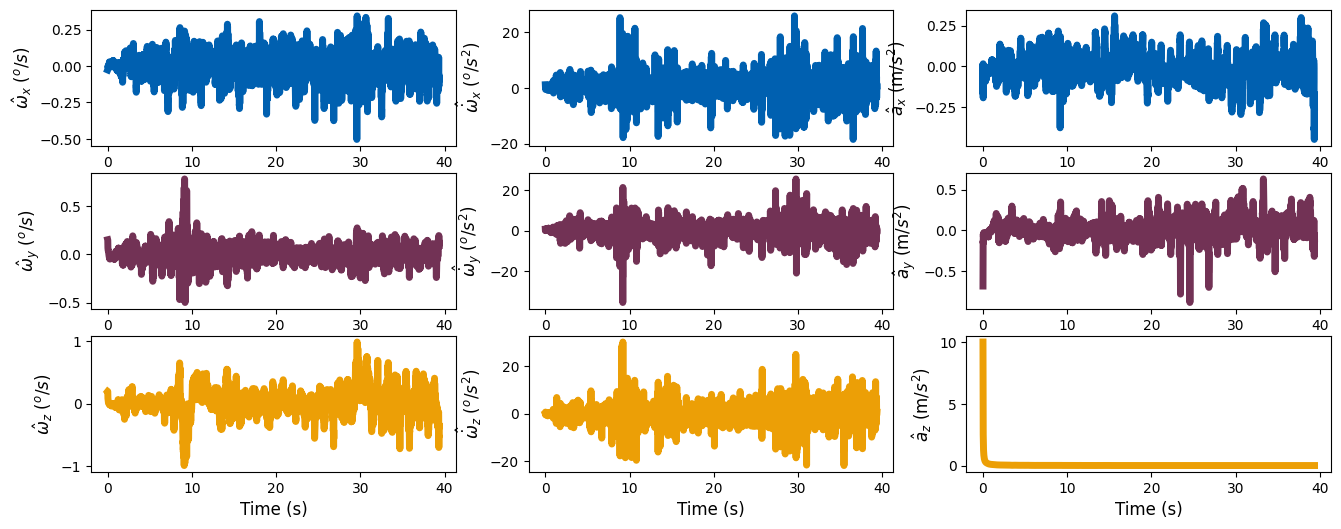

In [18]:
fig2, ax2 = plt.subplots(3, 3, figsize = (16, 6))
ax2[0,0].plot(time, state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[1,0].plot(time, state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,0].plot(time, state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax2[0,0].set_ylabel("$\hat{\omega}_x$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$\hat{\omega}_y$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$\hat{\omega}_z$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1,1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2,1].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax2[0,1].set_ylabel("$\hat{\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\hat{\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\hat{\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

ax2[0,2].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax2[1,2].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax2[2,2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
ax2[0,2].set_ylabel("$\hat{a}_x$ (m/$s^2$)", fontsize=12)
ax2[1,2].set_ylabel("$\hat{a}_y$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_ylabel("$\hat{a}_z$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

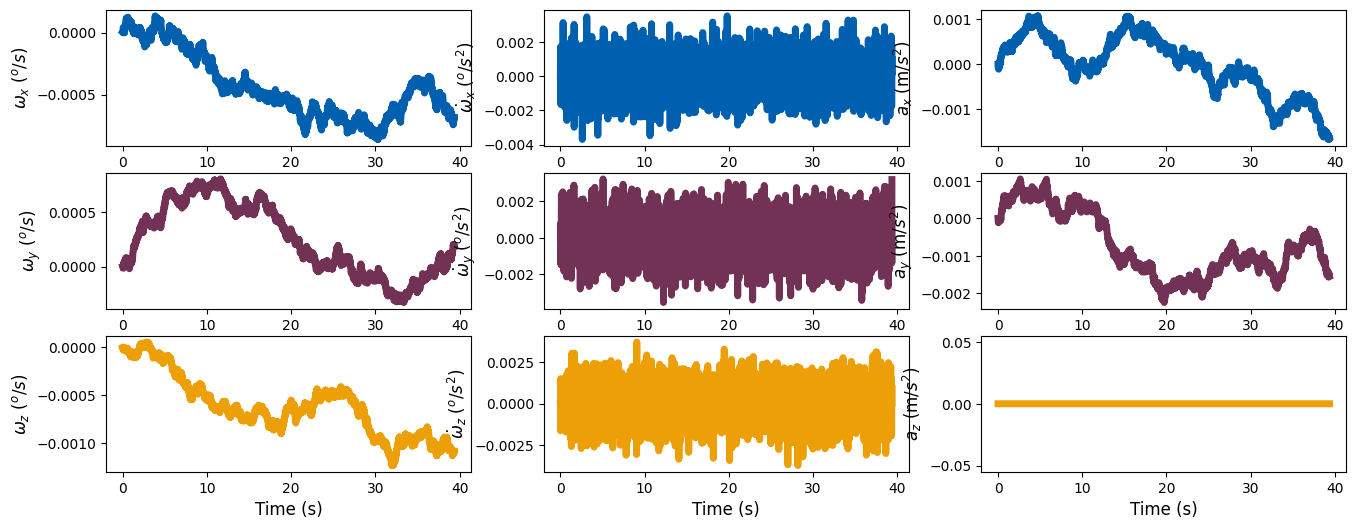

In [20]:
fig2, ax2 = plt.subplots(3, 3, figsize = (16, 6))
ax2[0,0].plot(time, state_hist[:,0], linewidth=5, color = "#0060B0", label = "${\omega}_x$")
ax2[1,0].plot(time, state_hist[:,1], linewidth=5, color = "#723255", label = "${\omega}_y$")
ax2[2,0].plot(time, state_hist[:,2], linewidth=5, color = "#EC9F06", label = "${\omega}_z$")
ax2[0,0].set_ylabel("${\omega}_x$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("${\omega}_y$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("${\omega}_z$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, state_hist[:,3], linewidth=5, color = "#0060B0", label = "${\dot{\omega}}_x$")
ax2[1,1].plot(time, state_hist[:,4], linewidth=5, color = "#723255", label = "${\dot{\omega}}_y$")
ax2[2,1].plot(time, state_hist[:,5], linewidth=5, color = "#EC9F06", label = "${\dot{\omega}}_z$")
ax2[0,1].set_ylabel("${\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("${\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("${\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

ax2[0,2].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$a_x$")
ax2[1,2].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$a_y$")
ax2[2,2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$a_z$")
ax2[0,2].set_ylabel("${a}_x$ (m/$s^2$)", fontsize=12)
ax2[1,2].set_ylabel("${a}_y$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_ylabel("${a}_z$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

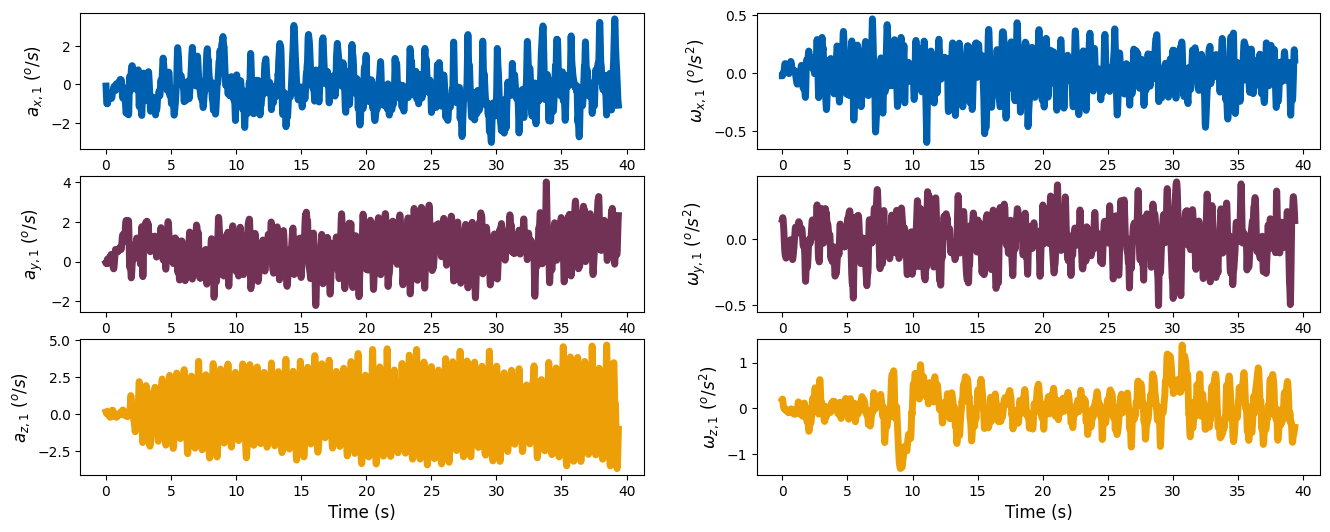

In [21]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time, cal_meas[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[1,0].plot(time, cal_meas[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,0].plot(time, cal_meas[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, cal_meas[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1,1].plot(time, cal_meas[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2,1].plot(time, cal_meas[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

Inertial navigation

In [22]:
from scipy.spatial.transform import Rotation as R

class InertialNavigation:
    def __init__(self, dt):
        self.dt = dt
        self.position = np.zeros(3)
        self.velocity = np.zeros(3)
        self.angle = np.zeros(3)
        self.orientation = np.array([1, 0, 0, 0])  # Initial quaternion (w, x, y, z)
        self.pos_hist = []
        self.ori_hist = []
        self.ang_hist = []
        self.vel_hist = []
    
    def update(self, angular_velocity, acceleration):
        self.orientation = self._update_orientation(self.orientation, angular_velocity)
        accel_world = self._rotate_vector(acceleration, self.orientation)
        self.velocity += accel_world * self.dt
        self.position += self.velocity * self.dt
        self.angle = self.quaternion_to_euler(self.orientation)
        self.pos_hist.append(self.position.copy())
        self.ori_hist.append(self.orientation.copy())
        self.ang_hist.append(self.angle.copy())
        self.vel_hist.append(self.velocity.copy())
    
    def _update_orientation(self, quat, angular_velocity):
        wx, wy, wz = self.DEG2RAD(angular_velocity)
        omega = np.array([0, wx, wy, wz]) * 0.5 * self.dt
        dq = self._quaternion_multiply(quat, omega)
        quat_new = quat + dq
        return quat_new / np.linalg.norm(quat_new)  # Normalize to maintain unit quaternion
    
    def _quaternion_multiply(self, q, r):
        w1, x1, y1, z1 = q
        w2, x2, y2, z2 = r
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2
        ])
    
    def _rotate_vector(self, vec, quat):
        q_vec = np.array([0, *vec])
        q_conj = np.array([quat[0], -quat[1], -quat[2], -quat[3]])
        rotated_vec = self._quaternion_multiply(self._quaternion_multiply(quat, q_vec), q_conj)
        return rotated_vec[1:]
    
    def get_position_and_orientation(self):
        return self.position, self.orientation

    def DEG2RAD(self, deg):
        return deg * (math.pi / 180)
    
    def quaternion_to_euler(self, q, degrees=True):
        rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # Scipy expects [x, y, z, w] format
        euler_angles = rotation.as_euler('xyz', degrees=degrees)
        return euler_angles

angular_velocity_data = state_est_hist[:,0:3]
acceleration_data = state_est_hist[:,6:9]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_est_hist = np.array(ins.pos_hist)
ang_est_hist = np.array(ins.ang_hist)
vel_est_hist = np.array(ins.vel_hist)

Text(0, 0.5, '$\\hat{r}$ ($m$)')

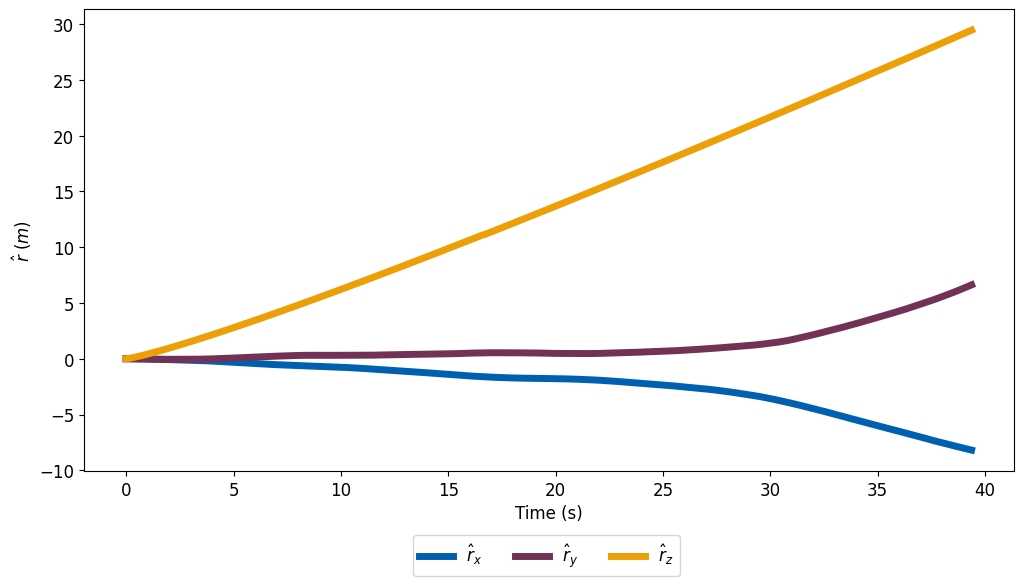

In [23]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], pos_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{r}_x$")
ax1.plot(time[:], pos_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{r}_y$")
ax1.plot(time[:], pos_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{r}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{r}$ ($m$)", fontsize=12)

In [24]:
angular_velocity_data = cal_meas[:,3:6]
acceleration_data = cal_meas[:,0:3]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_raw_hist = np.array(ins.pos_hist)
ang_raw_hist = np.array(ins.ang_hist)
vel_raw_hist = np.array(ins.vel_hist)

angular_velocity_data = state_hist[:,0:3]
acceleration_data = state_hist[:,6:9]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_hist = np.array(ins.pos_hist)
ang_hist = np.array(ins.ang_hist)
vel_hist = np.array(ins.vel_hist)

Text(0.5, 0, 'Time (s)')

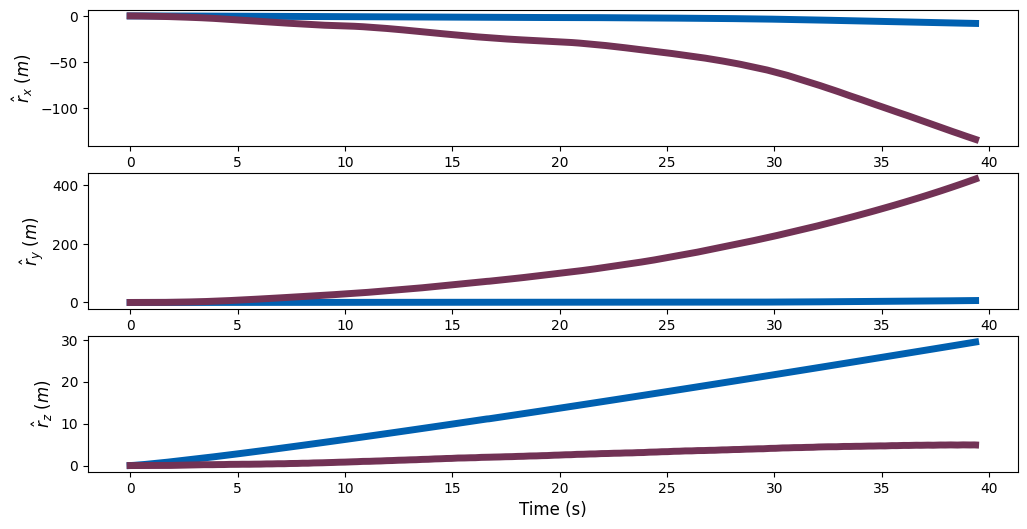

In [26]:
fig2, ax2 = plt.subplots(3, 1, figsize = (12, 6))
ax2[0].plot(time, pos_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[0].plot(time, pos_raw_hist[:,0], linewidth=5, color = "#723255", label = "${\omega}_{x,1}$")
ax2[1].plot(time, pos_est_hist[:,1], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_y$")
ax2[1].plot(time, pos_raw_hist[:,1], linewidth=5, color = "#723255", label = "${\omega}_{y,1}$")
ax2[2].plot(time, pos_est_hist[:,2], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_z$")
ax2[2].plot(time, pos_raw_hist[:,2], linewidth=5, color = "#723255", label = "${\omega}_{z,1}$")
ax2[0].set_ylabel("$\hat{r}_x$ ($m$)", fontsize=12)
ax2[1].set_ylabel("$\hat{r}_y$ ($m$)", fontsize=12)
ax2[2].set_ylabel("$\hat{r}_z$ ($m$)", fontsize=12)
ax2[2].set_xlabel("Time (s)", fontsize=12)


Text(0, 0.5, '$\\hat{\\Theta}$ ($m$)')

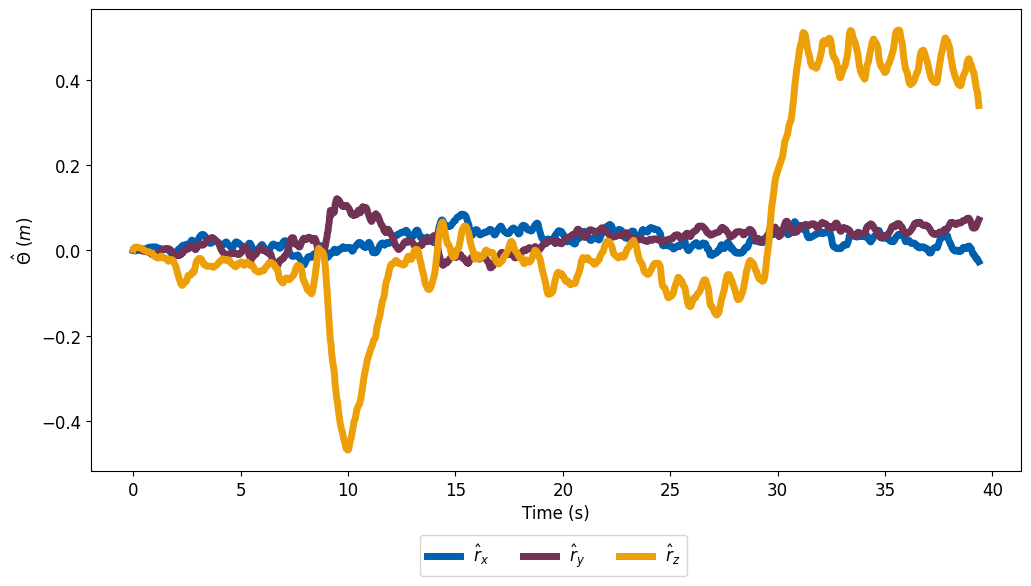

In [28]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], ang_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{r}_x$")
ax1.plot(time[:], ang_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{r}_y$")
ax1.plot(time[:], ang_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{r}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\Theta}$ ($m$)", fontsize=12)

## Allan Variance Visualization

DISIMU omega hat: quantization    0.00000000000000
white           0.00000000000000
flicker         0.02367972131592
walk            0.14660719948698
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00005249754770
white           0.00054699547071
flicker         0.00000000000000
walk            0.16914806513040
ramp            0.02653948187908
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00000000000000
flicker         0.01671204243123
walk            0.12227002103265
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

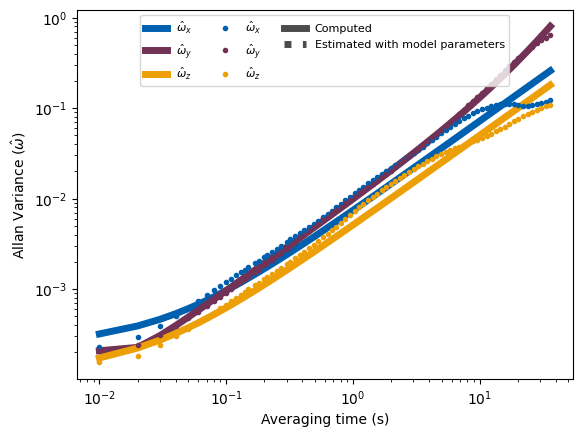

In [172]:
# DISIMU, omega hat
tau_wx, avar_wx = allan_variance.compute_avar(state_est_hist[:,0], dt)
tau_wy, avar_wy = allan_variance.compute_avar(state_est_hist[:,1], dt)
tau_wz, avar_wz = allan_variance.compute_avar(state_est_hist[:,2], dt)
params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
print(f"DISIMU omega hat: {params_wx}, {params_wy}, {params_wz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_wx, avar_pred_wx, label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_pred_wy, label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_pred_wz, label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_wx, avar_wx, '.', label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_wy, '.', label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_wz, '.', label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 1])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

IMU 1 SF hat: quantization    0.00008852096205
white           0.00453540585074
flicker         0.00420553262440
walk            0.00671252185903
ramp            0.00072029200078
Name: 0, dtype: float64, quantization    0.00013718283816
white           0.00430294512701
flicker         0.00619682421712
walk            0.00513981448573
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00012302927704
white           0.00437224618688
flicker         0.00526551805937
walk            0.00524115745664
ramp            0.00050477212984
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.00005336094649
white           0.00464714759180
flicker         0.00343038800539
walk            0.00596470722259
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00004860458428
white           0.00464718044547
flicker         0.00253513566108
walk            0.00752691665916
ramp            0.00053870831959
Name: 0, dtype: float64, quantization    0.00008

Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

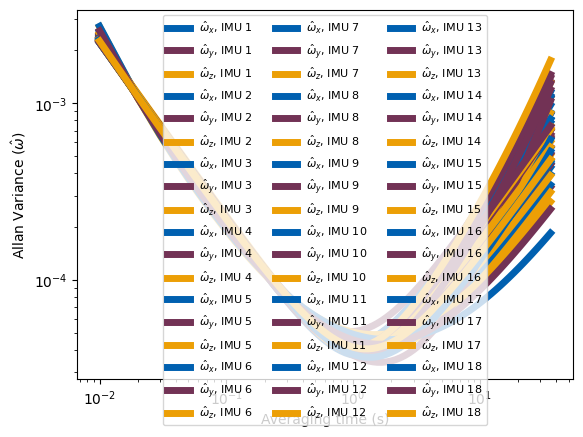

In [173]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\hat{\omega}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\hat{\omega}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\hat{\omega}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

DISIMU omega hat: quantization    0.00006040002624
white           0.00000000000000
flicker         0.01162416262812
walk            0.06641908190492
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00006416185343
white           0.00000000000000
flicker         0.00989891138776
walk            0.06324513307467
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.0000000000000
white           0.0000000000000
flicker         0.1468505274325
walk            0.2589373353596
ramp            0.0000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

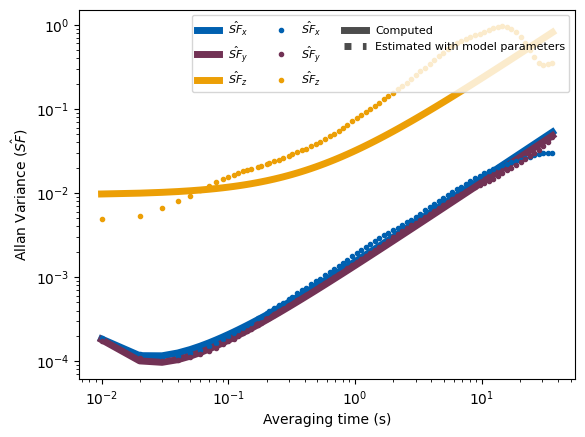

In [174]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(state_est_hist[:,6], dt)
tau_fy, avar_fy = allan_variance.compute_avar(state_est_hist[:,7], dt)
tau_fz, avar_fz = allan_variance.compute_avar(state_est_hist[:,8], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU omega hat: {params_fx}, {params_fy}, {params_fz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")

# sigma =  0.01 / np.sqrt(tau_fz)
# plt.loglog(tau_fz, sigma, label=r'$\sigma = \frac{Q}{\sqrt{T}}$', linewidth=3)
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

IMU 1 SF hat: quantization    0.00004048358138
white           0.00331162886141
flicker         0.00000000000000
walk            0.01860385209168
ramp            0.00245209333131
Name: 0, dtype: float64, quantization    0.00007316841464
white           0.00317196395176
flicker         0.00000000000000
walk            0.02058558060203
ramp            0.00114813056491
Name: 0, dtype: float64, quantization    0.00009452562173
white           0.00302766495385
flicker         0.00561642130735
walk            0.01618433991795
ramp            0.00221532955755
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.00013754992040
white           0.00260805574306
flicker         0.00945172617819
walk            0.01155351899081
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00003654083485
white           0.00325607937420
flicker         0.00386075936190
walk            0.01631234084728
ramp            0.00189500680541
Name: 0, dtype: float64, quantization    0.000

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

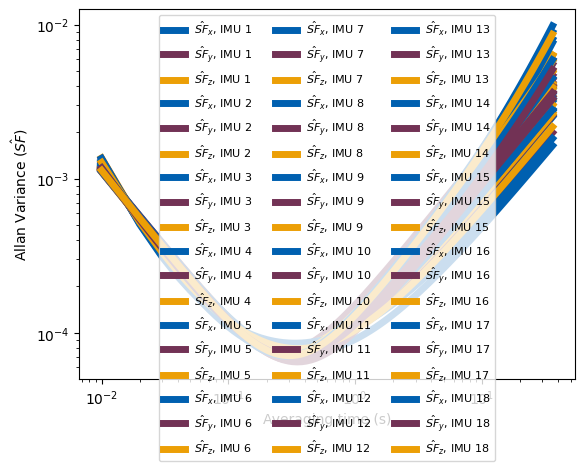

In [175]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\hat{SF}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\hat{SF}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\hat{SF}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

Text(0, 0.5, '$\\hat{\\omega}$ (rad/s)')

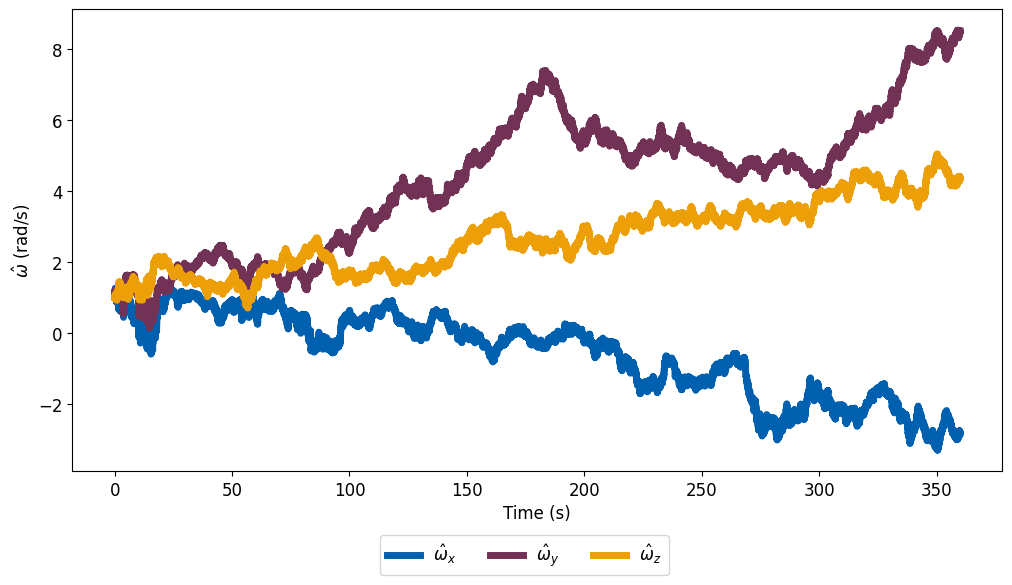

In [176]:
# single IMU, omega hat
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(time[:], state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(time[:], state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.5, 2])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ (rad/s)", fontsize=12)

Text(0, 0.5, '$\\omega$ (rad/s)')

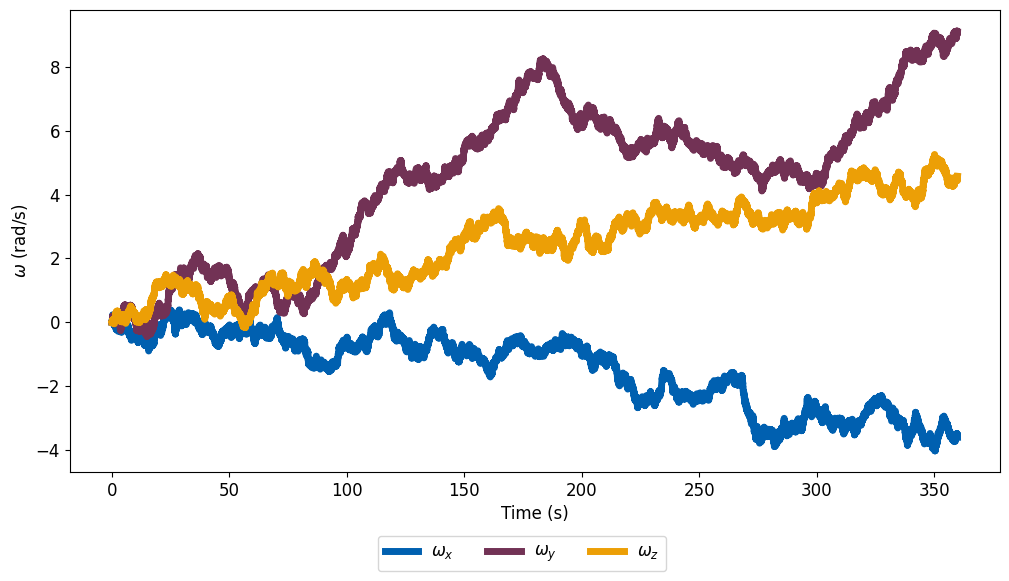

In [177]:
# omega
fig2, ax2 = plt.subplots(figsize = (12, 6))
ax2.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax2.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax2.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax2.set_xlabel("Time (s)", fontsize=12)
# ax2.set_ylim([-0.005, 0.005]) # using same units as above
ax2.set_ylabel("$\omega$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

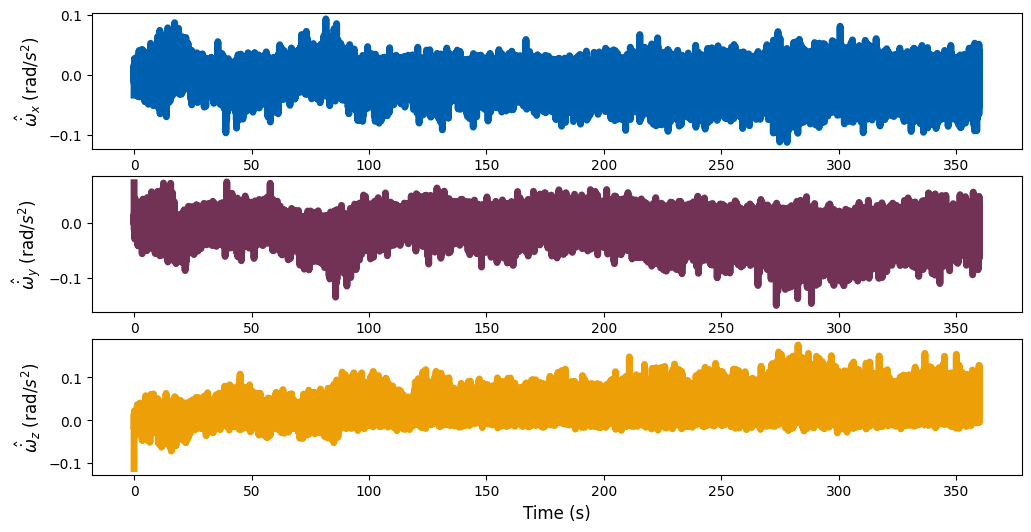

In [178]:
# fused omega hat dot
fig3, ax3 = plt.subplots(3, 1, figsize = (12, 6))
ax3[0].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax3[1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax3[2].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
# ax3[0].set_ylim([-0.1, 0.1])
# ax3[1].set_ylim([-0.1, 0.1])
# ax3[2].set_ylim([-0.1, 0.1])
ax3[0].set_ylabel("$\hat{\dot{\omega}}_x$ (rad/$s^2$)", fontsize=12)
ax3[1].set_ylabel("$\hat{\dot{\omega}}_y$ (rad/$s^2$)", fontsize=12)
ax3[2].set_ylabel("$\hat{\dot{\omega}}_z$ (rad/$s^2$)", fontsize=12)
ax3[2].set_xlabel("Time (s)", fontsize=12)

Text(0, 0.5, '$\\dot{\\omega}$ (rad/s)')

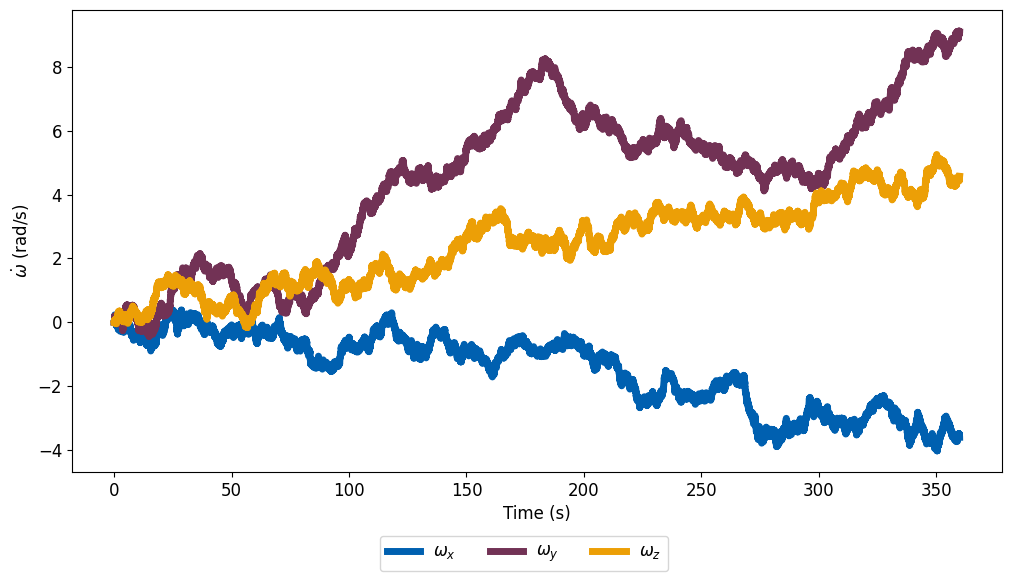

In [179]:
# dynamics, omega dot
fig4, ax4 = plt.subplots(figsize = (12, 6))
ax4.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax4.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax4.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax4.set_xlabel("Time (s)", fontsize=12)
# ax4.set_ylim([-0.005, 0.005]) # using same units as above
ax4.set_ylabel("$\dot{\omega}$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

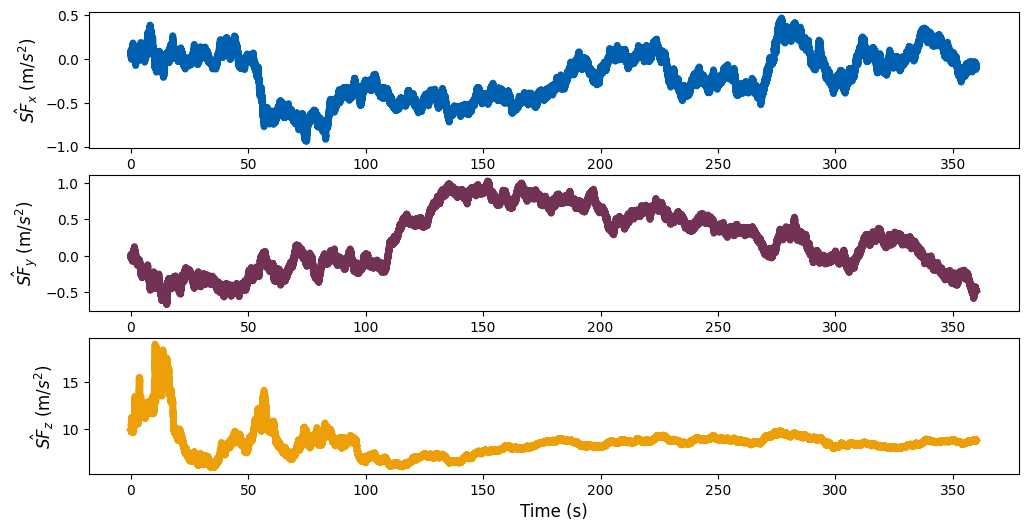

In [180]:
# system, SF hat
fig5, ax5 = plt.subplots(3, 1, figsize = (12, 6))
ax5[0].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax5[1].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax5[2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
# ax5[0].set_ylim([-0.1, 0.1])
# ax5[1].set_ylim([-0.1, 0.1])
# ax5[2].set_ylim([-0.1, 0.1])
ax5[0].set_ylabel("$\hat{SF}_x$ (m/$s^2$)", fontsize=12)
ax5[1].set_ylabel("$\hat{SF}_y$ (m/$s^2$)", fontsize=12)
ax5[2].set_ylabel("$\hat{SF}_z$ (m/$s^2$)", fontsize=12)
ax5[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

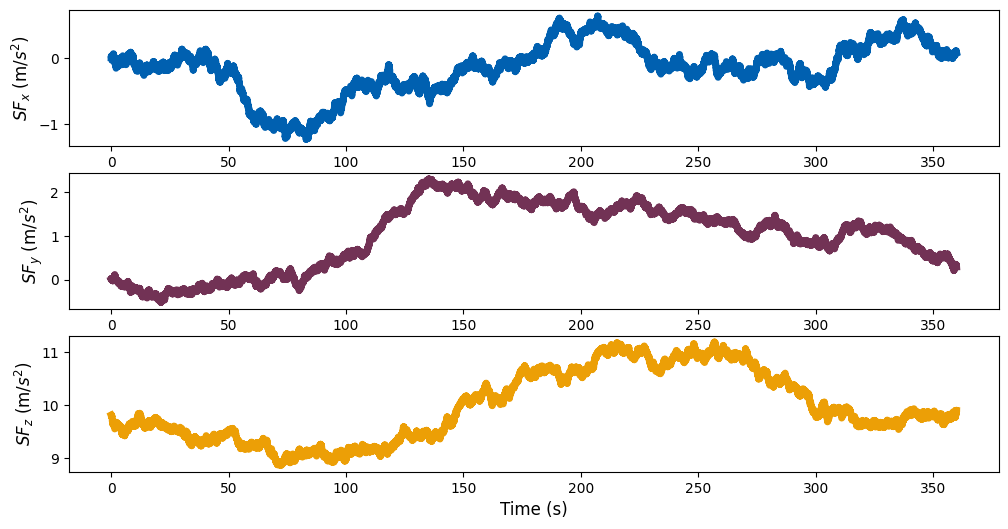

In [181]:
# dynamics, SF
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,6])
# plt.plot(time, state_hist[:,7])
# plt.plot(time, state_hist[:,8])
# plt.title("specific force")

fig6, ax6 = plt.subplots(3, 1, figsize = (12, 6))
ax6[0].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$SF_x$")
ax6[1].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$SF_y$")
ax6[2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$SF_z$")
# ax3[0].set_ylim([-0.0025, 0.0025])
# ax3[1].set_ylim([-0.0025, 0.0025])
# ax3[2].set_ylim([-0.0025, 0.0025])
# ax6[0].set_ylim([-0.005, 0.005])
# ax6[1].set_ylim([-0.005, 0.005])
# ax6[2].set_ylim([-0.005, 0.005])
ax6[0].set_ylabel("$SF_x$ (m/$s^2$)", fontsize=12)
ax6[1].set_ylabel("$SF_y$ (m/$s^2$)", fontsize=12)
ax6[2].set_ylabel("$SF_z$ (m/$s^2$)", fontsize=12)
ax6[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

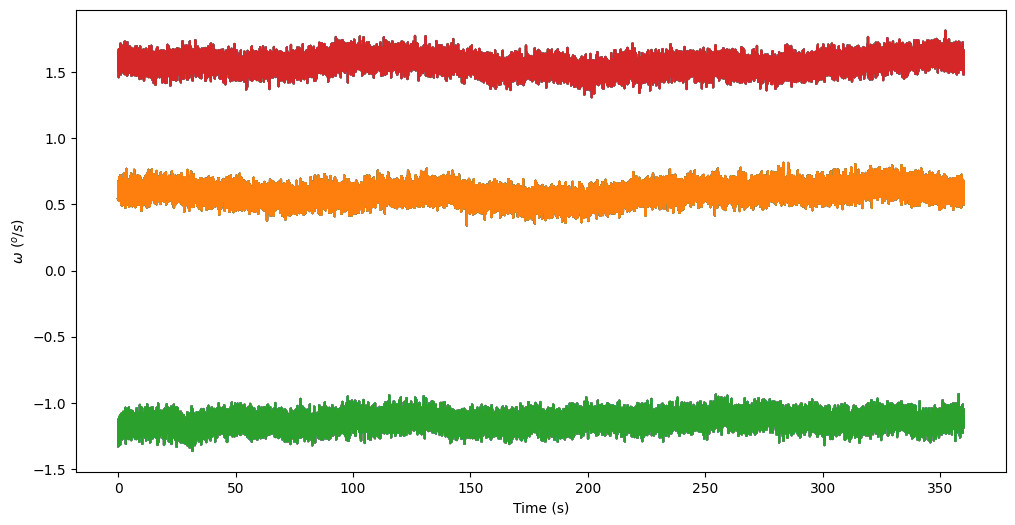

In [182]:
plt.figure(figsize = (12, 6))
for jth in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

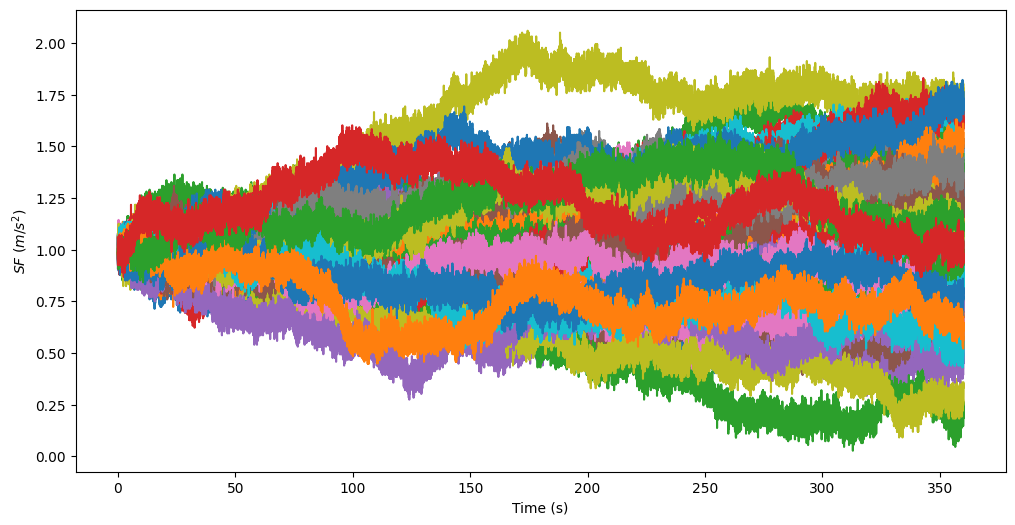

In [183]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")

In [184]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,9])
plt.plot(time, state_est_hist[:,10])
plt.plot(time, state_est_hist[:,11])
plt.title("RW")

IndexError: index 9 is out of bounds for axis 1 with size 9

<Figure size 1200x600 with 0 Axes>

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,12])
plt.plot(time, state_est_hist[:,13])
plt.plot(time, state_est_hist[:,14])
plt.title("RW")

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,15])
plt.plot(time, state_est_hist[:,16])
plt.plot(time, state_est_hist[:,17])
plt.title("RW")

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,18])
plt.plot(time, state_est_hist[:,19])
plt.plot(time, state_est_hist[:,20])
plt.title("GM")